# Text Classification Model (Transformer)

Training a text classification deep learning model using HuggingFace Transformers library

In [2]:
import csv
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import tensorflow as tf
import transformers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [3]:
# notebook settings

MAX_SEQUENCE_LENGTH = 128
VALIDATION_SPLIT = 0.3
MODEL_NAME = "distilroberta-base"

## Loading the data

We read the data from `./data/imdb.csv` and perform some basic preprocessing.

In [4]:
texts, labels = [], [] # empty lists for the sentences and labels

def preprocess_text(input_text):
    return input_text.replace("<br />", " ").strip()

with open("./data/imdb.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for row in reader:
        texts.append(preprocess_text(row[0]))
        if row[1] == "positive":
            labels.append(1)
        elif row[1] == "negative":
            labels.append(0)
        else:
            print("WARN: invalid label")
            
assert len(texts) == len(labels)

print(texts[0], labels[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.  The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.  It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  I would say the main appeal of the show is due to the fact that it goes where other sho

Next, we need to **tokenize** the data to convert each unique subword into a number. This is needed to allow our embedding inside the pretrained Transformer model to work. Each pretrained model has its own tokenizer.

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
tokenized_texts = [tokenizer.encode(t) for t in texts]

data = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts,
                                                     padding='post',
                                                     maxlen=MAX_SEQUENCE_LENGTH)

Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors


In [7]:
# convert the category label to one-hot encoding
labels = tf.keras.utils.to_categorical(np.asarray(labels))
print('[i] Shape of data tensor:', data.shape)
print('[i] Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels,
                                                  test_size=VALIDATION_SPLIT)

print('[i] Number of entries in each category:')
print("[+] Training:", y_train.sum(axis=0))
print("[+] Validation:", y_val.sum(axis=0))

[i] Shape of data tensor: (50000, 128)
[i] Shape of label tensor: (50000, 2)
[i] Number of entries in each category:
[+] Training: [17562. 17438.]
[+] Validation: [7438. 7562.]


Inspecting the training data

In [8]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [   38   655   794  2322   162    25    98 15455    24    21 19907     6
    38  1705    75   224    38    21  1227    13    24     6    53    25
    38  3996    55     6    38  2226    10  5840    13 10548     6     8
   300 21090     7     5   239  1389     9 11267  1476     4  1491    95
  1476     6    53 16318    36 23324 17477  8528    54   581    28  1088
    66    13    10 19500     6  8039    54   581  3549    15   645     8
   120   409    19    24     6   157   313 30815     6  1692  1380  8039
   145  1224    88  1789   828  5559   528     7    49  1762     9  2014
  2417    50  1789   676    43 26535 10548     6    47   189   555  3473
    19    99    16  9800  7603 17220   212  2923   114    47    64   120
    11  2842    19   110 20292   526     4     2]

One-hot label:
 [0. 1.]


## Building the model

In [9]:
model = transformers.TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, hidden_dropout_prob=0.1)

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.0)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(loss=lossfn,
              optimizer=opt,
              metrics=[acc])

model.summary()

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

2022-08-28 05:32:40.435187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36580 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:4e:00.0, compute capability: 8.0
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  81527808  
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 82,119,938
Trainable params: 82,119,938
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [10]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./data/best_transformer.h5",
                                                      monitor='val_categorical_accuracy',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [11]:
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      callbacks=[model_checkpoint],
                      epochs=4, batch_size=32)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1094/1094 [==============================] - 67s 51ms/step - loss: 0.2764 - categorical_accuracy: 0.8791 - val_loss: 0.2069 - val_categorical_accuracy: 0.9176

Epoch 00001: val_categorical_accuracy improved from -inf to 0.91760, saving model to ./d

Visualize performance

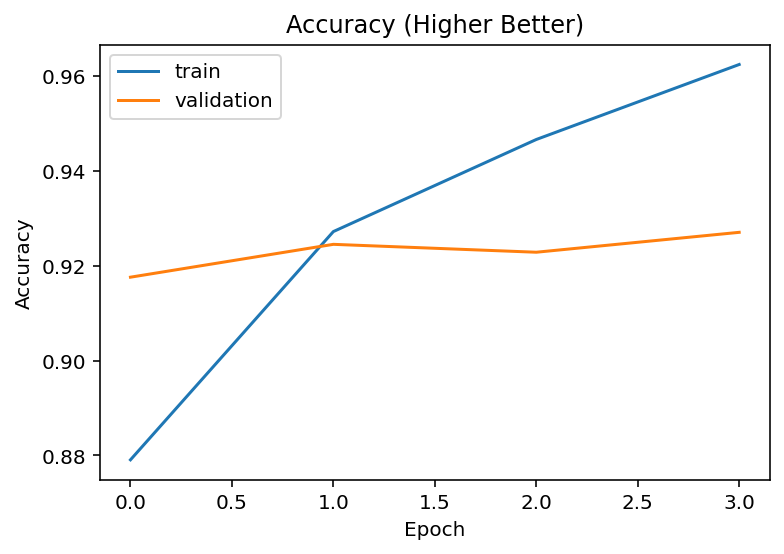

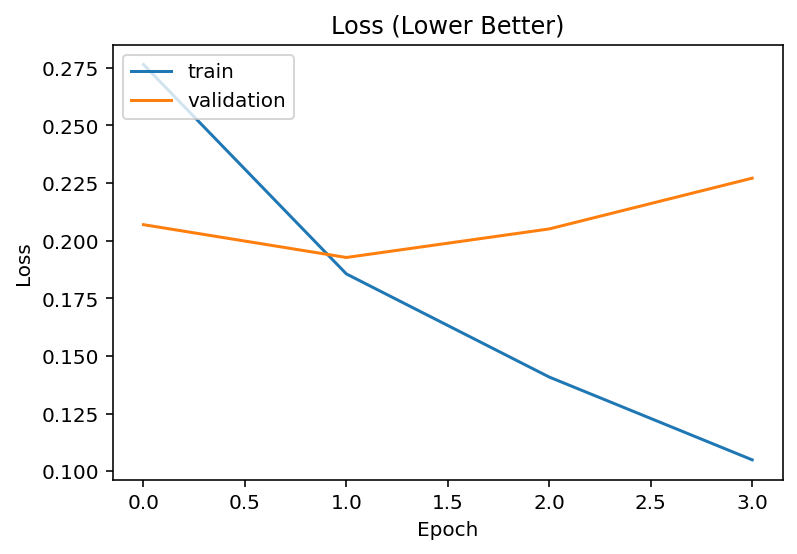

In [12]:
plt.plot(model_log.history['categorical_accuracy'])
plt.plot(model_log.history['val_categorical_accuracy'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()